In [1]:
#import dask.dataframe as pd
import numpy as np
import pandas as pd
import gc
import os
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
import random
import re

PATH = '.'
print(os.listdir(f'{PATH}'))



['sample_submission.csv', 'data', 'periods_test.csv', 'periods_train.csv', 'test_active.csv', 'test.csv', 'train_active.csv', 'train.csv', '.ipynb_checkpoints', 'best.hdf5', 'train.ipynb', 'submit_nn_p3_0.2260.csv', '.git', 'ru.bin', 'ru.vec', 'dask-worker-space', 'data.h5', 'tr_desc_pad.pk', 'tr_desc.npy', 'cc.ru.300.bin', 'desc_vectors.npz', 'tr_desc.npz', 'train-ft-images.ipynb', 'test_ru.txt']


In [2]:
use_pretrained = True
use_images     = True
finetune_pretrained = False

In [3]:
df_train = pd.read_csv(f'{PATH}/train.csv')
df_test  = pd.read_csv(f'{PATH}/test.csv')

In [4]:
df_y_train = df_train['deal_probability']
df_x_train = df_train.drop(['deal_probability'], axis=1)

In [5]:
df_train.head(10)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797
5,51e0962387f7,bbfad0b1ad0a,Татарстан,Чистополь,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Авто люлька,В хорошем состоянии,1300.0,9,2017-03-28,Private,eb6ad1231c59d3dc7e4020e724ffe8e4d302023ddcbb99...,796.0,0.80323
6,c4f260a2b48a,08f469d2e6f7,Нижегородская область,Нижний Новгород,Для дома и дачи,Ремонт и строительство,Сантехника и сауна,NaN,NaN,Водонагреватель 100 литров нержавейка плоский,Электро водонагреватель накопительный на 100 л...,11000.0,125,2017-03-23,Private,0330f6ac561f5db1fa8226dd5e7e127b5671d44d075a98...,2823.0,0.00000
7,6b71309d6a8a,fef86baa002c,Пермский край,Пермь,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Джинсы,26,Бойфренды colins,Бойфренды в хорошем состоянии.,500.0,61,2017-03-25,Private,9bab29a519e81c14f4582024adfebd4f11a4ac71d323a6...,567.0,0.80323
8,c5b969cb63a2,055825270190,Оренбургская область,Оренбург,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Платья и юбки,> 50 (XXL),Платье,54 раз мер очень удобное,500.0,85,2017-03-17,Private,75ce06d1f939a31dfb2af8ac55f08fa998fa336d13ee05...,415.0,0.00000
9,b1570962e68c,f9e8f831d94c,Нижегородская область,Нижний Новгород,Личные вещи,Детская одежда и обувь,Для девочек,Обувь,25,Полу ботиночки замш натур.Бамбини,По стельке 15.5см мерить приокский район. Цвет...,400.0,136,2017-03-22,Company,54fb8521135fda77a860bfd2fac6bf46867ab7c06796e3...,46.0,0.00000


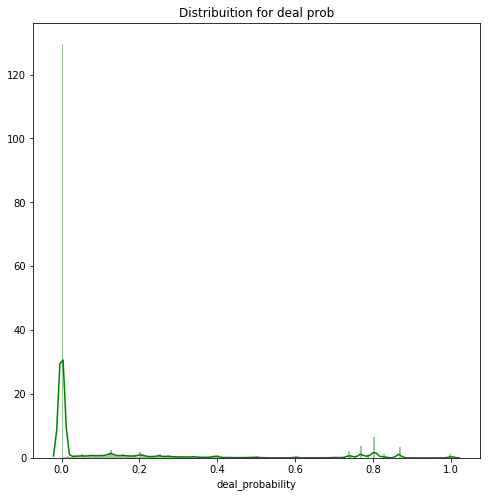

In [6]:
plt.figure(figsize = (8, 8))
plt.title('Distribuition for deal prob')
sns.distplot(df_y_train ,color='green', kde=True,bins=200)
plt.show()

In [7]:
#df_y_train = df_y_train.round()

In [8]:
df_y_train.head(10)

0    0.12789
1    0.00000
2    0.43177
3    0.80323
4    0.20797
5    0.80323
6    0.00000
7    0.80323
8    0.00000
9    0.00000
Name: deal_probability, dtype: float64

In [9]:
df_x_train.head(10)


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0
5,51e0962387f7,bbfad0b1ad0a,Татарстан,Чистополь,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Авто люлька,В хорошем состоянии,1300.0,9,2017-03-28,Private,eb6ad1231c59d3dc7e4020e724ffe8e4d302023ddcbb99...,796.0
6,c4f260a2b48a,08f469d2e6f7,Нижегородская область,Нижний Новгород,Для дома и дачи,Ремонт и строительство,Сантехника и сауна,NaN,NaN,Водонагреватель 100 литров нержавейка плоский,Электро водонагреватель накопительный на 100 л...,11000.0,125,2017-03-23,Private,0330f6ac561f5db1fa8226dd5e7e127b5671d44d075a98...,2823.0
7,6b71309d6a8a,fef86baa002c,Пермский край,Пермь,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Джинсы,26,Бойфренды colins,Бойфренды в хорошем состоянии.,500.0,61,2017-03-25,Private,9bab29a519e81c14f4582024adfebd4f11a4ac71d323a6...,567.0
8,c5b969cb63a2,055825270190,Оренбургская область,Оренбург,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Платья и юбки,> 50 (XXL),Платье,54 раз мер очень удобное,500.0,85,2017-03-17,Private,75ce06d1f939a31dfb2af8ac55f08fa998fa336d13ee05...,415.0
9,b1570962e68c,f9e8f831d94c,Нижегородская область,Нижний Новгород,Личные вещи,Детская одежда и обувь,Для девочек,Обувь,25,Полу ботиночки замш натур.Бамбини,По стельке 15.5см мерить приокский район. Цвет...,400.0,136,2017-03-22,Company,54fb8521135fda77a860bfd2fac6bf46867ab7c06796e3...,46.0


In [10]:
df_x_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 17 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null object
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
dtypes: float64(2), int64(1), object(14)
memory usage: 195.0+ MB


In [11]:
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508438 entries, 0 to 508437
Data columns (total 17 columns):
item_id                 508438 non-null object
user_id                 508438 non-null object
region                  508438 non-null object
city                    508438 non-null object
parent_category_name    508438 non-null object
category_name           508438 non-null object
param_1                 485528 non-null object
param_2                 275209 non-null object
param_3                 202107 non-null object
title                   508438 non-null object
description             508438 non-null object
price                   477853 non-null float64
item_seq_number         508438 non-null int64
activation_date         508438 non-null object
user_type               508438 non-null object
image                   465829 non-null object
image_top_1             465829 non-null float64
dtypes: float64(2), int64(1), object(14)
memory usage: 65.9+ MB


In [12]:
# viewing # of unique value in each column 
for col in df_x_train.columns:
    print(col, len(df_x_train[col].unique()))

item_id 1503424
user_id 771769
region 28
city 1733
parent_category_name 9
category_name 47
param_1 372
param_2 272
param_3 1220
title 788377
description 1317103
price 17007
item_seq_number 28232
activation_date 21
user_type 3
image 1390837
image_top_1 3063


In [13]:
value = { 
    'image_top_1' : 3067,
    'param_1' : "_NA_",
    'param_2' : "_NA_",
    'param_3' : "_NA_",
    'description' : "_NA_",
    'title' : "_NA_",
}

df_x_train = df_x_train.fillna(value=value)
df_test = df_test.fillna(value=value)

In [14]:
#df_x_train
user_id_in_both = np.intersect1d(df_x_train['user_id'].values, df_test['user_id'].values) 

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import argparse
from fastText import load_model

#create config init
config = argparse.Namespace()


/home/antor/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
def to_categorical_idx(col, df_trn, df_test):
    merged = pd.concat([df_trn[col], df_test[col]])
    train_size = df_trn[col].shape[0]
    idxs, uniques = pd.factorize(merged)
    
    return idxs[:train_size], idxs[train_size:], uniques

In [17]:
tr_reg, te_reg, tknzr_reg    = to_categorical_idx('region', df_x_train, df_test)
tr_pcn, te_pcn, tknzr_pcn    = to_categorical_idx('parent_category_name', df_x_train, df_test)
tr_cn, te_cn, tknzr_cn       = to_categorical_idx('category_name', df_x_train, df_test)
tr_ut, te_ut, tknzr_ut       = to_categorical_idx('user_type', df_x_train, df_test)
tr_city, te_city, tknzr_city = to_categorical_idx('city', df_x_train, df_test)

tr_p1, te_p1, tknzr_p1 = to_categorical_idx('param_1', df_x_train, df_test)
tr_p2, te_p2, tknzr_p2 = to_categorical_idx('param_2', df_x_train, df_test)
tr_p3, te_p3, tknzr_p3 = to_categorical_idx('param_3', df_x_train, df_test)

In [18]:
tr_week = pd.to_datetime(df_x_train['activation_date']).dt.weekday.astype(np.int32).values
te_week = pd.to_datetime(df_test['activation_date']).dt.weekday.astype(np.int32).values
tr_week = np.expand_dims(tr_week, axis=-1)
te_week = np.expand_dims(te_week, axis=-1)

In [19]:
tr_imgt1 = df_x_train['image_top_1'].astype(np.int32).values
te_imgt1 = df_test['image_top_1'].astype(np.int32).values
tr_imgt1 = np.expand_dims(tr_imgt1, axis=-1)
te_imgt1 = np.expand_dims(te_imgt1, axis=-1)

In [20]:
epsilon = 1e-8
tr_price = np.log(df_x_train['price'] + epsilon)
te_price = np.log(df_test['price'] + epsilon)
tr_price[tr_price.isna()] = -1.
te_price[te_price.isna()] = -1.

tr_price = np.expand_dims(tr_price, axis=-1)
te_price = np.expand_dims(te_price, axis=-1)

In [21]:
tr_itemseq = np.log(df_x_train['item_seq_number'])
te_itemseq = np.log(df_test['item_seq_number'])
#tr_itemseq = df_x_train['item_seq_number']
#te_itemseq = df_test['item_seq_number']
# price_tr[price_tr.isna()] = -1.
# price_te[price_te.isna()] = -1.

tr_itemseq = np.expand_dims(tr_itemseq, axis=-1)
te_itemseq = np.expand_dims(te_itemseq, axis=-1)

In [22]:
from timeit import timeit
from functools import lru_cache
gc.collect()



20

In [23]:
from keras.preprocessing.sequence import pad_sequences
config.maxlen       = 256
config.maxlen_title = 16
config.emb_title = config.emb_desc = 300
_emb_nwords = 50000 

In [24]:
tknzr = Tokenizer(num_words=_emb_nwords if finetune_pretrained else None, lower=True)
tknzr.fit_on_texts(pd.concat([
    df_x_train['description'], 
    df_x_train['title'], 
    df_x_train['param_1'],
    df_x_train['param_2'],
    df_x_train['param_3'],
    df_test['description'], 
    df_test['title'], 
    df_test['param_1'],
    df_test['param_2'],
    df_test['param_3'],
]).values)

In [25]:
emb_nwords = _emb_nwords if finetune_pretrained else len(tknzr.word_index)

print(emb_nwords, len(tknzr.word_index))
print([(k,v) for k,v in tknzr.word_index.items()][49900:50100])
print(tknzr.texts_to_sequences(["результат голубые складная оф кругликовской отказались ‐ бесп"]))
    
if use_pretrained:
    lang_model = load_model('cc.ru.300.bin')
    embedding_matrix = np.zeros((emb_nwords+1, config.emb_desc), dtype=np.float32)
    for word, i in list(tknzr.word_index.items())[:emb_nwords]:
        embedding_vector = lang_model.get_word_vector(word)[:config.emb_desc]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
else:
    embedding_matrix = None


899487 899487
[('гладко', 49901), ('zuiko', 49902), ('проектами', 49903), ('коста', 49904), ('укреплены', 49905), ('обменяюсь', 49906), ('фару', 49907), ('чемоданов', 49908), ('6x8', 49909), ('53215', 49910), ('английских', 49911), ('240см', 49912), ('низкотемпературная', 49913), ('корректирует', 49914), ('3u', 49915), ('celeron®', 49916), ('офд', 49917), ('откосами', 49918), ('територии', 49919), ('domani', 49920), ('ninebot', 49921), ('джой', 49922), ('81а', 49923), ('бойфренд', 49924), ('→→', 49925), ('torx', 49926), ('мотопомпы', 49927), ('xc60', 49928), ('монголия', 49929), ('делюкс', 49930), ('кирпичными', 49931), ('days', 49932), ('обзоров', 49933), ('visconte', 49934), ('кармен', 49935), ('ттр', 49936), ('откатались', 49937), ('рисунке', 49938), ('эвкалипт', 49939), ('гигиеническая', 49940), ('885', 49941), ('чёткий', 49942), ('простоквашино', 49943), ('инвентарем', 49944), ('платят', 49945), ('карликовых', 49946), ('включающей', 49947), ('1ый', 49948), ('авиационный', 49949), 

In [26]:
 embedding_matrix[emb_nwords]

array([ 0.00737474,  0.01385682,  0.01551736, -0.00456215,  0.00853153,
       -0.00082167,  0.00768578,  0.02383661, -0.01979357,  0.00506881,
        0.006119  , -0.01625614, -0.03284595,  0.02375597, -0.02181865,
        0.00757564,  0.00172099,  0.00147627, -0.01454801,  0.01361349,
       -0.02178275, -0.00224919, -0.02571386,  0.04668503,  0.00148914,
        0.01057487, -0.01011867, -0.00842633,  0.0148282 , -0.0125519 ,
        0.04294941, -0.00537102, -0.01480368, -0.00479335,  0.02054754,
       -0.00129261,  0.00666329, -0.0071127 , -0.00556935,  0.01141116,
       -0.02508699, -0.07069963,  0.02206567,  0.03042065, -0.00037694,
        0.01723636, -0.02740122, -0.01903443,  0.00655512, -0.00276362,
        0.01243195,  0.02675766,  0.00524326,  0.0564792 , -0.01050619,
        0.01111184,  0.02512535, -0.00025607, -0.02286075, -0.04346476,
        0.00289525,  0.05060014, -0.01306664, -0.00144434,  0.00918397,
       -0.03793854, -0.02059463,  0.00254167, -0.00450311, -0.00

In [27]:
tr_desc_seq = tknzr.texts_to_sequences(df_x_train['description'].values)
te_desc_seq = tknzr.texts_to_sequences(df_test['description'].values)

tr_title_seq = tknzr.texts_to_sequences(df_x_train['title'].values)
te_title_seq = tknzr.texts_to_sequences(df_test['title'].values)

tr_desc_pad = pad_sequences(tr_desc_seq, maxlen=config.maxlen)
te_desc_pad = pad_sequences(te_desc_seq, maxlen=config.maxlen)

tr_title_pad = pad_sequences(tr_title_seq, maxlen=config.maxlen_title)
te_title_pad = pad_sequences(te_title_seq, maxlen=config.maxlen_title)

In [28]:
gc.collect()

0

In [29]:
## categorical
config.len_reg   = len(tknzr_reg)
config.len_pcn   = len(tknzr_pcn)
config.len_cn    = len(tknzr_cn) 
config.len_ut    = len(tknzr_ut)
config.len_city  = len(tknzr_city)
config.len_week  = 7
config.len_imgt1 = int(df_x_train['image_top_1'].max())+1
config.len_p1    = len(tknzr_p1)
config.len_p2    = len(tknzr_p2)
config.len_p3    = len(tknzr_p3)

## continuous
config.len_price   = 1
config.len_itemseq = 1


In [30]:
## categorical
max_emb = 64
config.emb_reg   = min(max_emb,(config.len_reg   + 1)//2)
config.emb_pcn   = min(max_emb,(config.len_pcn   + 1)//2)
config.emb_cn    = min(max_emb,(config.len_cn    + 1)//2)
config.emb_ut    = min(max_emb,(config.len_ut    + 1)//2)
config.emb_city  = min(max_emb,(config.len_city  + 1)//2)
config.emb_week  = min(max_emb,(config.len_week  + 1)//2)
config.emb_imgt1 = min(max_emb,(config.len_imgt1 + 1)//2)
config.emb_p1    = min(max_emb,(config.len_p1    + 1)//2)
config.emb_p2    = min(max_emb,(config.len_p2    + 1)//2)
config.emb_p3    = min(max_emb,(config.len_p3    + 1)//2)

#continuous
config.emb_price   = 16
config.emb_itemseq = 16

#text

In [31]:
valid_idx = list(df_y_train.sample(frac=0.2, random_state=1991).index)
train_idx = list(df_y_train[np.invert(df_y_train.index.isin(valid_idx))].index)

In [32]:
[print(k.shape) for k in [tr_reg, tr_pcn, tr_cn, tr_ut, tr_city, tr_week, tr_imgt1, tr_p1, tr_p2, tr_p3, tr_price, tr_itemseq]]
X      = np.array([tr_reg, tr_pcn, tr_cn, tr_ut.squeeze(), tr_city, tr_week.squeeze(), tr_imgt1.squeeze(), 
                   tr_p1, tr_p2, tr_p3, tr_price.squeeze(), tr_itemseq.squeeze(), df_x_train['image'].values])
X_test = np.array([te_reg, te_pcn, te_cn, te_ut.squeeze(), te_city, te_week.squeeze(), te_imgt1.squeeze(), 
                   te_p1, te_p2, te_p3, te_price.squeeze(), te_itemseq.squeeze(), df_test['image'].values])

Y = df_y_train

(1503424,)
(1503424,)
(1503424,)
(1503424,)
(1503424,)
(1503424, 1)
(1503424, 1)
(1503424,)
(1503424,)
(1503424,)
(1503424, 1)
(1503424, 1)


In [33]:
tr_reg

array([ 0,  1,  2, ..., 10,  6, 11])

In [34]:
gc.collect()


0

In [35]:
from keras.layers import Input, Embedding, Dense, BatchNormalization, Activation, Dropout
from keras.layers import GlobalMaxPool1D, GlobalMaxPool2D
from keras.layers import concatenate, Flatten
from keras.layers import LSTM, CuDNNGRU, CuDNNLSTM, GRU, Bidirectional
from keras.models import Model
from keras.utils import multi_gpu_model
from keras.applications import *
import jpeg4py as jpeg
import cv2
from keras import backend as K

from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from keras_contrib.layers.normalization import InstanceNormalization

### rmse loss for keras
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [36]:
if use_images:
    CROP_SIZE = 224
    image_feature_extractor = 'ResNet50'
    freeze_until = None# 'res5b_branch2a'
    
    classifier = globals()[image_feature_extractor]

    kwargs = {
        'include_top' : False,
        'weights'     : 'imagenet',
        'input_shape' : (CROP_SIZE, CROP_SIZE, 3), 
        'pooling'     : 'avg',
     }

    classifier_model = classifier(**kwargs)
    
    if freeze_until is not None:
        trainable = False
        n_trainable = 0

        for i, layer in enumerate(classifier_model.layers):
            if layer.name == freeze_until:
                trainable = True
            if trainable:
                n_trainable += 1
            layer.trainable = trainable

    classifier_model.summary()

    def preprocess_image(img):
    
        # find `preprocess_input` function specific to the classifier
        classifier_to_module = { 
            'NASNetLarge'       : 'nasnet',
            'NASNetMobile'      : 'nasnet',
            'DenseNet121'       : 'densenet',
            'DenseNet161'       : 'densenet',
            'DenseNet201'       : 'densenet',
            'InceptionResNetV2' : 'inception_resnet_v2',
            'InceptionV3'       : 'inception_v3',
            'MobileNet'         : 'mobilenet',
            'ResNet50'          : 'resnet50',
            'VGG16'             : 'vgg16',
            'VGG19'             : 'vgg19',
            'Xception'          : 'xception',

            'VGG16Places365'        : 'vgg16_places365',
            'VGG16PlacesHybrid1365' : 'vgg16_places_hybrid1365',

            'SEDenseNetImageNet121' : 'se_densenet',
            'SEDenseNetImageNet161' : 'se_densenet',
            'SEDenseNetImageNet169' : 'se_densenet',
            'SEDenseNetImageNet264' : 'se_densenet',
            'SEInceptionResNetV2'   : 'se_inception_resnet_v2',
            'SEMobileNet'           : 'se_mobilenets',
            'SEResNet50'            : 'se_resnet',
            'SEResNet101'           : 'se_resnet',
            'SEResNet154'           : 'se_resnet',
            'SEInceptionV3'         : 'se_inception_v3',
            'SEResNext'             : 'se_resnet',
            'SEResNextImageNet'     : 'se_resnet',

            'ResNet152'             : 'resnet152',
            'AResNet50'             : 'aresnet50',
            'AXception'             : 'axception',
            'AInceptionV3'          : 'ainceptionv3',
        }

        if image_feature_extractor in classifier_to_module:
            classifier_module_name = classifier_to_module[image_feature_extractor]
        else:
            classifier_module_name = 'xception'

        preprocess_input_function = getattr(globals()[classifier_module_name], 'preprocess_input')
        return preprocess_input_function(img.astype(np.float32))
    



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [37]:
config.batch_size = 64 if use_images else 1024

In [38]:
def get_model():
    do = 0
    bn = True
    
    #K.clear_session()
    inp_reg = Input(shape=(1, ), name='inp_region')
    emb_reg = Embedding(config.len_reg, config.emb_reg, name='emb_region')(inp_reg)
    
    inp_pcn = Input(shape=(1, ), name='inp_parent_category_name')
    emb_pcn = Embedding(config.len_pcn, config.emb_pcn, name='emb_parent_category_name')(inp_pcn)

    inp_cn = Input(shape=(1, ), name='inp_category_name')
    emb_cn = Embedding(config.len_cn, config.emb_cn, name="emb_category_name" )(inp_cn)
    
    inp_ut = Input(shape=(1, ), name='inp_user_type')
    emb_ut = Embedding(config.len_ut, config.emb_ut, name='emb_user_type' )(inp_ut)
    
    inp_city = Input(shape=(1, ), name='inp_city')
    emb_city = Embedding(config.len_city, config.emb_city, name='emb_city' )(inp_city)

    inp_week = Input(shape=(1, ), name='inp_week')
    emb_week = Embedding(config.len_week, config.emb_week, name='emb_week' )(inp_week)

    inp_imgt1 = Input(shape=(1, ), name='inp_imgt1')
    emb_imgt1 = Embedding(config.len_imgt1, config.emb_imgt1, name='emb_imgt1')(inp_imgt1)
    
    inp_p1 = Input(shape=(1, ), name='inp_p1')
    emb_p1 = Embedding(config.len_p1, config.emb_p1, name='emb_p1')(inp_p1)
    
    inp_p2 = Input(shape=(1, ), name='inp_p2')
    emb_p2 = Embedding(config.len_p2, config.emb_p2, name='emb_p2')(inp_p2)
    
    inp_p3 = Input(shape=(1, ), name='inp_p3')
    emb_p3 = Embedding(config.len_p3, config.emb_p3, name='emb_p3')(inp_p3)
    

    conc_cate = concatenate([emb_reg, emb_pcn,  emb_cn, emb_ut, emb_city, emb_week, emb_imgt1, 
                             emb_p1, emb_p2, emb_p3], 
                            axis=-1, name='concat_categorical_vars')
    
    conc_cate = Flatten()(conc_cate)
    
    inp_price = Input(shape=(1, ), name='inp_price')
    emb_price = inp_price#InstanceNormalization()(inp_price)
    #emb_price = Dense(config.emb_price, activation='tanh', name='emb_price')(inp_price)

    inp_itemseq = Input(shape=(1, ), name='inp_itemseq')
    emb_itemseq = inp_itemseq# InstanceNormalization()(inp_itemseq)
    emb_itemseq = Dense(config.emb_itemseq, activation='tanh', name='emb_itemseq')(emb_itemseq)
    
    inp_filesize = Input(shape=(1, ), name='inp_filesize')
    emb_filesize = inp_filesize#InstanceNormalization()(inp_price)

    conc_cont = concatenate([conc_cate, emb_price, emb_itemseq, emb_filesize], axis=-1)
    
    x = conc_cont
    
    x = Dense(512)(x)
    if bn: x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Dense(512)(x)
    if bn: x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    if do > 0.: x = Dropout(do)(x)
        
    x = Dense(512)(x)
    if bn: x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    if do > 0.: x = Dropout(do)(x)

    ### text

    embedding_text = Embedding(emb_nwords+1, config.emb_desc, 
                               weights = [embedding_matrix], 
                               trainable=True if finetune_pretrained else False,
                               name='emb_desc')

    inp_desc = Input(shape=(config.maxlen, ), name='inp_desc')
    emb_desc = embedding_text(inp_desc)
    
    desc_layer = Bidirectional(CuDNNGRU(config.emb_desc, return_sequences=True))(emb_desc)
    desc_layer = Bidirectional(CuDNNGRU(config.emb_desc, return_sequences=False))(desc_layer)
    
    inp_title = Input(shape=(config.maxlen_title, ), name='inp_title')
    emb_title = embedding_text(inp_title)
    
    title_layer = Bidirectional(CuDNNGRU(config.emb_desc, return_sequences=True))(emb_title)
    title_layer = Bidirectional(CuDNNGRU(config.emb_desc, return_sequences=False))(title_layer)

    conc_desc = concatenate([x, desc_layer, title_layer], axis=-1)
    
    if use_images:
        inp_image = Input(shape=(CROP_SIZE, CROP_SIZE, 3), name='inp_image')
        image_features = classifier_model(inp_image)
        conc_desc = concatenate([conc_desc, image_features], axis=-1)
        
    conc_desc = Dense(2048)(conc_desc)
    if bn: conc_desc = BatchNormalization()(conc_desc)
    conc_desc = Activation(activation='relu')(conc_desc)

    conc_desc = Dense(1024)(conc_desc)
    if bn: conc_desc = BatchNormalization()(conc_desc)
    conc_desc = Activation(activation='relu')(conc_desc)
    
    conc_desc = Dense(512)(conc_desc)
    if bn: conc_desc = BatchNormalization()(conc_desc)
    conc_desc = Activation(activation='relu')(conc_desc)
    if do > 0.: conc_desc = Dropout(do)(conc_desc)

    conc_desc = Dense(256)(conc_desc)
    if bn: conc_desc = BatchNormalization()(conc_desc)
    conc_desc = Activation(activation='relu')(conc_desc)
    if do > 0.: conc_desc = Dropout(do)(conc_desc)

    outp = Dense(1, activation='sigmoid', name='output')(conc_desc)

    inputs = [inp_reg, inp_pcn, inp_cn, inp_ut, inp_city, inp_week, inp_imgt1, inp_p1, inp_p2, inp_p3,
              inp_price, inp_itemseq, inp_desc, inp_title, inp_filesize]
    
    if use_images:
        inputs.append(inp_image)
            
    model = Model(inputs = inputs, outputs = outp)
    return model


In [39]:
def gen(idx, valid=False):
    
    if use_images:
        load_img_fast_jpg  = lambda img_path: jpeg.JPEG(img_path).decode()
        xi = np.empty((config.batch_size, CROP_SIZE, CROP_SIZE, 3), dtype=np.float32)

    x = np.empty((config.batch_size, X.shape[0]-1 + 1), dtype=np.float32)
    y = np.empty((config.batch_size, ), dtype=np.float32)
    
    print(x.shape, y.shape)
    
    xd = np.empty((config.batch_size, config.maxlen      ), dtype=np.float32)
    xt = np.empty((config.batch_size, config.maxlen_title), dtype=np.float32)
    
    batch = 0
    i = 0
    while True:
        
        if i == len(idx):
            i = 0
            if not valid:
                random.shuffle(idx)
            
        x[batch,:12] = X[:12,idx[i]]
        y[batch,...] = Y[idx[i]]
                
        n_vect = tr_desc_pad[idx[i]].shape[0]
        i_vect = config.maxlen - n_vect
        xd[batch, i_vect:, ...] = tr_desc_pad[idx[i]]
        xd[batch, :i_vect, ...] = 0

        n_vect = min(tr_title_pad[idx[i]].shape[0], config.maxlen_title)
        i_vect = config.maxlen_title - n_vect
        path = f'{PATH}/data/competition_files/train_jpg/{X[12,idx[i]]}.jpg'
        
        xt[batch, i_vect:, ...] = tr_title_pad[idx[i]][:n_vect]
        xt[batch, :i_vect, ...] = 0
        
        filesize = -1
        try:
            filesize = os.path.getsize(path) / 151868. # biggest file
        except Exception:
            pass
        
        x[batch,12] = 0 #filesize

        if use_images:
            xi[batch, ...] = 0.
            try:
                _img = load_img_fast_jpg(path)
                _img = cv2.resize(_img, (CROP_SIZE, CROP_SIZE))
                _img = preprocess_image(_img)
                xi[batch, ...] = _img
            except Exception:
                pass
            
        batch += 1
        i += 1
        
        if batch == config.batch_size:
            _x = [x[:, 0], x[:, 1], x[:, 2], x[:, 3], 
                  x[:, 4], x[:, 5], x[:, 6], x[:, 7], 
                  x[:, 8], x[:, 9], x[:,10], x[:,11],
                  xd, xt,  x[:,12] ]
            if use_images:
                _x.append(xi)
                
            yield(_x, y)
            
            batch = 0
    

In [40]:
model = get_model()
model.summary()
model = multi_gpu_model(model, gpus=2)
# model.compile(optimizer=RMSprop(lr=0.0005, decay=0.00001), loss = root_mean_squared_error, metrics=['mse', root_mean_squared_error])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_region (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
inp_parent_category_name (Input (None, 1)            0                                            
__________________________________________________________________________________________________
inp_category_name (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
inp_user_type (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
inp_city (

In [41]:
### callbacks
checkpoint = ModelCheckpoint(
    f'best-use_pretrained{use_pretrained}-use_images{use_images}-finetune_pretrained{finetune_pretrained}.hdf5', 
    monitor='val_loss', verbose=1, save_best_only=True)
early = EarlyStopping(patience=5, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1, mode='min')


In [42]:
model.compile(optimizer=Adam(lr=1e-2, amsgrad=True) if use_images else RMSprop(lr=1e-2), 
              loss = root_mean_squared_error, metrics=[root_mean_squared_error])

In [43]:
model.fit_generator(
    generator        = gen(train_idx),
    steps_per_epoch  = len(train_idx) // config.batch_size, 
    validation_data  = gen(valid_idx, valid=True), 
    validation_steps = len(valid_idx) // config.batch_size, 
    epochs = 100, 
    callbacks=[checkpoint, early, reduce_lr], 
    verbose=1)

(64, 13)Epoch 1/100
 (64,)
18792/18792 [==============================] - 8540s 454ms/step - loss: 0.2316 - root_mean_squared_error: 0.2316 - val_loss: 0.2269 - val_root_mean_squared_error: 0.2269

Epoch 00001: val_loss improved from inf to 0.22689, saving model to best.hdf5
Epoch 2/100
18792/18792 [==============================] - 8532s 454ms/step - loss: 0.2274 - root_mean_squared_error: 0.2274 - val_loss: 0.2266 - val_root_mean_squared_error: 0.2266

Epoch 00002: val_loss improved from 0.22689 to 0.22656, saving model to best.hdf5
Epoch 3/100
18792/18792 [==============================] - 8537s 454ms/step - loss: 0.2256 - root_mean_squared_error: 0.2256 - val_loss: 0.2238 - val_root_mean_squared_error: 0.2238

Epoch 00003: val_loss improved from 0.22656 to 0.22376, saving model to best.hdf5
Epoch 4/100
18792/18792 [==============================] - 8543s 455ms/step - loss: 0.2238 - root_mean_squared_error: 0.2238 - val_loss: 0.2233 - val_root_mean_squared_error: 0.2233

Epoch 00004

KeyboardInterrupt: 

In [ ]:
pred = model.predict(X_test)

subm = pd.read_csv(f'{PATH}/sample_submission.csv')
subm['deal_probability'] = pred
subm.to_csv('submit_{}_{:.4f}.csv'.format('nn_p3', 0.2226), index=False)